# Задача матчинга товаров и предложений от Samokat.tech 

**Цели исследования:**

Команда матчинга и машинного обучения работает с предложениями продавцов маркетплейса, ассортиментом, товарами конкурентов.

Заказчик предлагает решить задачу по матчингу товаров:
Предстоит реализовать финальную часть пайплайна матчинга. В ней следует принять решение для каждой пары (товар предлагаемый продавцом — товар на площадке), является ли она матчем или нет (бинарная классификация).
Для этого у каждой пары есть набор признаков и наборы векторов (картиночные и текстовые), которые описывают товары из этой пары.

В качестве метрики качества решения используется F-score.

**Ход исследования:**

На предоставленных исторических данных о поведении клиентов и расторжении договоров с банком будут натренированны модели классификации, предсказывающие уход клиентов.</br>

Иследование будет включать в себя следующие шаги:
   - Загрузка и подготовка данных
   - Исследование баланса классов
       - Выводы
   - Обучение разных моделей на кросс-валидации и подбор гиперпараметров
       - Отбор моделей классификации и их параметров с наибольшим значением f1-меры
       - Выводы
   - Проведение финального тестирования и формирование результата на тестовой выборке
       - Проверка f1-меры на тестовой выборке
   - Общий вывод

**Описание данных:**

Для решения задачи предоставляются обезличенные данные по товарным предложениям продавцов (offer) и товарах ассортимента маркетплейса "Мегамаркет" (goods).
В данных для каждого предложения уже найдены ближайшие товары из ассортимента и указаны основные признаки для этой пары. Необходимо только классифицировать, какая из пар является матчем, а какая — нет.

**Files**

- `train.csv` - тренировочный набор данных
- `test.csv` - тестовый набор

**Columns**

- `offer_depersanalised` и `goods_depersanalised` - идентификаторы предложения и товара соответственно
- `sum_length` - суммарная длина пары названий и атрибутов в символах
- `dist` - расстояние между названиями предложения и товара
- `attrs+title_score` - вероятность матча от рескоринговой модели
- `offer_price` и `item_price` - цена предложения и товара соответственно
- `goods_category_id` - категория товара
- `id` - идентификатор пары offer_depersanalised + $ + goods_depersanalised
- `target` (только в `train.csv`) - метка класса (0 - не матч, 1 - матч)

**Embeddings**

- `goods_image_vectors` и `offer_image_vectors` - содержат файлы с векторами изображений (`embed_deperson.npy`) и их идентификаторами (`items_deperson.npy`) для товаров ассортимента и предложений соответсвенно. Объекты в файлах соотносятся 1 к 1
- `goods_title_vectors` и `offer_title_vectors` - содержат файлы с векторами названий+атрибутов (`embed_deperson.npy`) и их идентификаторами (`items_deperson.npy`) для товаров ассортимента и предложений соответсвенно. Объекты в файлах соотносятся 1 к 1

**Результаты исследования:**

В результате исследования для предстказания матча выбрана и обучена модель на базе ансамбля моделей линейной регрессии, случайного леса и градиентного бустинга. Получено значение по метрике качества f-1 ~0.9 

## Загрузка и подготовка данных

### Загрузка библиотек и определение глобальных переменных

In [1]:
import gc
import multiprocessing
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from numpy import dot
from numpy.linalg import norm
from pathlib import Path
# from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.spatial import distance

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, root_mean_squared_error
from sklearn.model_selection import train_test_split, ParameterSampler, StratifiedKFold, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, SplineTransformer, FunctionTransformer
from sklearn.utils import shuffle

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from lightgbm import LGBMClassifier, LGBMRegressor, plot_importance

Определение переменных имен признаков и других полезных глобальных переменных:

In [2]:
# Расстояния
dists = ['l1', 'l2', 'dot', 'cos', 'canb']
titl_dists_lbls = [f't_{lbl}' for lbl in dists]
img_dists_lbls = [f'i_{lbl}' for lbl in dists]

# Категориальные и числовые признаки, 
num_cols = titl_dists_lbls + img_dists_lbls + ['sum_length', 'attrs+title_score', 'offer_price', 'goods_price']
cat_cols = ['offer_depersanalised', 'goods_depersanalised', 'goods_category_id']

# Эмбеддинги 
offer_img_lbls = [f'i_{c}' for c in range(256)]
goods_img_lbls = [f'i_{c}' for c in range(256, 512)]
offer_titl_lbls = [f't_{c}' for c in range(64)]
goods_titl_lbls = [f't_{c}' for c in range(64, 128)]

img_embs = offer_img_lbls + goods_img_lbls
titl_embs = offer_titl_lbls + goods_titl_lbls

float_cols = titl_embs + img_embs + titl_dists_lbls + img_dists_lbls + ['attrs+title_score']

tar_col = 'target'
cols_to_drop = set()

ru_name = {'offer_depersanalised': 'идентификаторы предложения',
           'goods_depersanalised': 'идентификаторы товара',
           'sum_length': 'длина пары названий и атрибутов',
           'attrs+title_score': 'вероятность матча',
           'offer_price': 'цена предложения',
           'item_price': 'цена товара',
           'goods_category_id': 'категория товара',
           'target': 'метка класса',
           't_l1': 'расстояние городских кварталов titl',
           't_l2': 'евклидово расстояние titl',
           't_dot': 'скалярное произведение titl',
           't_cos': 'косинус эмбедингов titl',
           't_canb': 'расстояние Канберры titl',
           'i_l1': 'расстояние городских кварталов img',
           'i_l2': 'евклидово расстояние img',
           'i_dot': 'скалярное произведение img',
           'i_cos': 'косинус эмбедингов img',
           'i_canb': 'расстояние Канберры img',
          }

dataset_path = '/home/panther/Documents/Deep Learning/kaggle/samokat/'

random_state=42

### Работа с эмбеддингами

Функции загрузки и объединения данных:

In [3]:
def load_embeds(side, kind, return_df=True):
    '''Функция грузит numpy эмбеддинги и либо отдает их в чистом виде, либо в виде датафрейма (return_df=True)'''
    path = dataset_path+f'{side}_{kind}_vectors'+'/'+f'{side}_{kind}_vectors'+'/'
    ids = np.load(path + 'items_deperson.npy').astype('int')
    embs = np.load(path + 'embed_deperson.npy')
    if return_df:
        inded_vecs = pd.DataFrame(embs, index=ids)
        return inded_vecs
    else:
        return ids, embs


Функция генерации признаков и выбора самой близкой пары эмбедингов:

In [4]:
def vecs_to_df(array, img=True):
    '''Из вывода функции emb_to_df: numpy.array(numpy.array(str), numpy.array(float))
    Получается pandas.DataFrame с векторами и расстояниями между ними
    '''
    prefix = 't'; v_len = 64
    if img:
        prefix = 'i'; v_len = 256
        
    c_names = [f'{prefix}_{str(i)}' for i in range(v_len*2)] + [f'{prefix}_{j}' for j in dists]
    return pd.DataFrame(index=array[0], data=np.stack(array[1]), columns=c_names, dtype='float32')

def filter_doubles(df, id, doubles_set):
    ''''''
    last_row = df.iloc[-1, :]
    df = df.loc[id].loc[~df.loc[id, 0].isin(doubles_set), :]
    if df.shape[0] == 0:
        return last_row
    else:
        return df.iloc[-1, :]

def downcast_df(df):
    '''Оптимизирует занимаемую датафреймом память по числовому типу'''
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
    return df
    
def emb_to_vec(ind_o, ind_g, op_key):
    '''Считает дисстанции между векторами а также компонует вектора попарно сообразно
    парам id offer_depersonalized$goods_depersonalized в датафрейме'''
    id = f'{ind_o}${ind_g}'
    try:
        # удаляю дубликаты векторов
        offer_vec = op[op_key][1].loc[ind_o, :]
        if offer_vec.shape[0] < op[op_key][0]:
            offer_vec = filter_doubles(op[op_key][1], ind_o, op[op_key][2])
                
        goods_vec = op[op_key][3].loc[ind_g, :] 
        if goods_vec.shape[0] < op[op_key][0]:
            goods_vec = filter_doubles(op[op_key][3], ind_g, op[op_key][4])

        l1 = np.linalg.norm(goods_vec - offer_vec, ord=1)
        l2 = np.linalg.norm(goods_vec - offer_vec, ord=2)
        dot = np.dot(goods_vec, offer_vec)
        cos = dot / (np.linalg.norm(goods_vec) * np.linalg.norm(offer_vec))
        canb = distance.canberra(goods_vec, offer_vec)
        return id, np.concatenate((offer_vec.values, goods_vec.values, np.array([l1, l2, dot, cos, canb])))
        
    except KeyError:
        return id, np.ones(op[op_key][0]*2 + 5)*-999
        
def chunk_array(array, n):
    '''Делит numpy.array на куски размером n строк'''
    for i, ind in enumerate(range(0, array.shape[0], n)):
        yield i, array[ind:ind + n]

def chunks_to_full_df(file_name):
    '''Объединяет поделенный на куски датафрейм {file_name}_*.lz4 в целый'''
    directory = Path(dataset_path)
    chunk_files = directory.glob(f'{file_name}_*.lz4')
    file_list = [pd.read_parquet(fpath) for fpath in chunk_files]
    
    return pd.concat(file_list)

def get_embdfs_and_write_to_disk(fname, pairs, chnk_i=None, img=True, write=True, chunks=False):
    vec_type = 'imgs'
    if not img:
        vec_type = 'titl'
        
    df = vecs_to_df(emb_to_vec_veczd(pairs[:, 0], pairs[:, 1], vec_type), img)
    if write:
        if chunks:
            df.to_parquet(dataset_path+f'{fname}_{chnk_i}.lz4', index=True, compression='lz4')
        else:
            df.to_parquet(dataset_path+f'{fname}.lz4', index=True, compression='lz4')
    else:
        return df

emb_to_vec_veczd = np.vectorize(emb_to_vec, otypes=[str, list])

Загрузка данных, включая эмбеддинги:

In [5]:
test_df = downcast_df(pd.read_csv(dataset_path + 'test.csv'))
train_df = downcast_df(pd.read_csv(dataset_path + 'train.csv'))

# определяю уникальные пары товаров для последующего поиска эмбеддингов 
test_pairs = test_df[['offer_depersanalised', 'goods_depersanalised']].drop_duplicates().to_numpy()
train_pairs = train_df[['offer_depersanalised', 'goods_depersanalised']].drop_duplicates().to_numpy()

# загрузка эмбеддингов
goods_titl_df = load_embeds('goods', 'title', return_df=True)
goods_imgs_df = load_embeds('goods', 'image', return_df=True)
offer_titl_df = load_embeds('offer', 'title', return_df=True)
offer_imgs_df = load_embeds('offer', 'image', return_df=True)

# множества повторяющихся значений эмбеддингов
ot_vc_set = (offer_titl_df.loc[:, 0].value_counts()[offer_titl_df.loc[:, 0].value_counts() >= 2].index)
oi_vc_set = (offer_imgs_df.loc[:, 0].value_counts()[offer_imgs_df.loc[:, 0].value_counts() >= 2].index)
gt_vc_set = (goods_titl_df.loc[:, 0].value_counts()[goods_titl_df.loc[:, 0].value_counts() >= 2].index)
gi_vc_set = (goods_imgs_df.loc[:, 0].value_counts()[goods_imgs_df.loc[:, 0].value_counts() >= 2].index)

op = {
    'imgs': [256, offer_imgs_df, oi_vc_set, goods_imgs_df, gi_vc_set],
    'titl': [64, offer_titl_df, ot_vc_set, goods_titl_df, gt_vc_set]
}



In [6]:
%%time
get_embdfs_and_write_to_disk('test_img_embs_ftrs_df', test_pairs)
get_embdfs_and_write_to_disk('test_titl_embs_ftrs_df', test_pairs, img=False)

CPU times: user 6min 42s, sys: 9.19 s, total: 6min 51s
Wall time: 6min 51s


In [7]:
%%time

for i, chunk_pairs in chunk_array(train_pairs, 650000):
    get_embdfs_and_write_to_disk('train_titl_embs_ftrs_df', chunk_pairs, i, img=False, chunks=True)

CPU times: user 12min 36s, sys: 8.56 s, total: 12min 45s
Wall time: 12min 41s


In [8]:
chunks_to_full_df('train_titl_embs_ftrs_df').to_parquet(dataset_path+'train_titl_embs_ftrs_df.lz4', index=True, compression='lz4')

In [9]:
%%time

for i, chunk_pairs in chunk_array(train_pairs, 650000):
    get_embdfs_and_write_to_disk('train_img_embs_ftrs_df', chunk_pairs, i, chunks=True)

CPU times: user 33min 27s, sys: 1min 36s, total: 35min 3s
Wall time: 38min 11s


In [12]:
chunks_to_full_df('train_img_embs_ftrs_df').to_parquet(dataset_path+'train_img_embs_ftrs_df.lz4', index=True, compression='lz4')

In [8]:
train_full_df = pd.merge(pd.read_parquet(dataset_path+'train_img_embs_ftrs_df.lz4'),
         pd.merge(pd.read_parquet(dataset_path+'train_titl_embs_ftrs_df.lz4'),
                  train_df,
                  left_index=True,
                  right_on='id'),
         left_index=True,
         right_on='id'
        )

In [9]:
test_full_df = pd.merge(pd.read_parquet(dataset_path+'test_img_embs_ftrs_df.lz4'),
         pd.merge(pd.read_parquet(dataset_path+'test_titl_embs_ftrs_df.lz4'),
                  test_df,
                  left_index=True,
                  right_on='id'),
         left_index=True,
         right_on='id'
        )

In [10]:
train_full_df.to_parquet(dataset_path+'train_FULL_wonans_df.lz4', index=True, compression='lz4')

In [11]:
test_full_df.to_parquet(dataset_path+'test_FULL_wonans_df.lz4', index=True, compression='lz4')

Получение уникальных идентификаторов пар "предложение-товар":

In [15]:
# РЕСУРСОЗАТРАТНО! Требуется как минимум 17 ГБ ОЗУ

# args = (
#     (offer_imgs_inds, offer_imgs_embs, goods_imgs_inds, goods_imgs_embs, train_u_pairs),
#     (offer_titl_inds, offer_titl_embs, goods_titl_inds, goods_titl_embs, test_u_pairs),
#     (offer_titl_inds, offer_titl_embs, goods_titl_inds, goods_titl_embs, train_u_pairs),
#     (offer_imgs_inds, offer_imgs_embs, goods_imgs_inds, goods_imgs_embs, test_u_pairs),
# )


# names = ('train_img_embs_ftrs_df.lz4', 'train_titl_embs_ftrs_df.lz4', 'test_img_embs_ftrs_df.lz4', 'test_titl_embs_ftrs_df.lz4')

# def multicore_ftrs_pooling(args, names):
#     p = multiprocessing.Pool(4)
#     results = p.map(make_vec_ftrs, args)
#     for i, ftrs_df in enumerate(results):
#         ftrs_df.to_parquet(dataset_path+names[i], index=True, compression='lz4')



In [ ]:
# multicore_ftrs_pooling(args1, names1)
# multicore_ftrs_pooling(args, names)

### Загрузка основных данных

In [18]:
test_df = pd.read_parquet(dataset_path + 'test_FULL_wonans_df.lz4')
train_df = pd.read_parquet(dataset_path + 'train_FULL_wonans_df.lz4')

## Исследовательский анализ данных

In [19]:
train_df.head()

t_l1      t_l2     t_dot     t_cos     t_canb   i_l1   i_l2  i_dot  \
0  5.515625  0.854492  0.030701  0.077576  45.073051 -999.0 -999.0 -999.0   
1  5.578125  0.888672 -0.004902 -0.012589  42.449364 -999.0 -999.0 -999.0   
2  5.765625  0.946777 -0.037750 -0.092102  44.763412 -999.0 -999.0 -999.0   
3  5.796875  0.937012 -0.041016 -0.103149  47.524933 -999.0 -999.0 -999.0   
4  5.132812  0.858398  0.031067  0.077820  44.220379 -999.0 -999.0 -999.0   

   i_cos  i_canb  sum_length  attrs+title_score  offer_price  goods_price  \
0 -999.0  -999.0          37           0.027267         1070          NaN   
1 -999.0  -999.0          38           0.050415          698          NaN   
2 -999.0  -999.0          38           0.087280          837          NaN   
3 -999.0  -999.0          38           0.087280          837          NaN   
4 -999.0  -999.0          38           0.079773         1085          NaN   

   offer_depersanalised  goods_depersanalised  goods_category_id  target  
0                295140               1396793               14.0       0  
1                 65291               1396586               14.0       0  
2                 39232               1396244               14.0       0  
3                 39232               1396513               14.0       0  
4                 65052               1396237               14.0       0

In [20]:
test_df.head()

t_l1      t_l2     t_dot     t_cos     t_canb   i_l1   i_l2  i_dot  \
0  5.757812  0.881348  0.015053  0.037354  46.618729 -999.0 -999.0 -999.0   
1  5.843750  0.917969 -0.017090 -0.042328  44.075443 -999.0 -999.0 -999.0   
2  6.207031  0.967285 -0.070190 -0.176514  47.502380 -999.0 -999.0 -999.0   
3  5.546875  0.900879  0.000626  0.001539  42.201565 -999.0 -999.0 -999.0   
4  6.207031  0.930664 -0.029449 -0.072998  50.169392 -999.0 -999.0 -999.0   

   i_cos  i_canb  sum_length  attrs+title_score  offer_price  goods_price  \
0 -999.0  -999.0          38           0.046997          368          NaN   
1 -999.0  -999.0          38           0.046997          368          NaN   
2 -999.0  -999.0          38           0.046997          368          NaN   
3 -999.0  -999.0          40           0.060211          634          NaN   
4 -999.0  -999.0          40           0.000370        14924      31840.0   

   offer_depersanalised  goods_depersanalised  goods_category_id  
0                 64819               1396468               14.0  
1                 64819               1396235               14.0  
2                 64819               1396318               14.0  
3                359959               1396281               14.0  
4                142700                717657                2.0

In [21]:
train_df.isna().sum()

t_l1                         0
t_l2                         0
t_dot                        0
t_cos                        0
t_canb                       0
i_l1                         0
i_l2                         0
i_dot                        0
i_cos                        0
i_canb                       0
sum_length                   0
attrs+title_score            0
offer_price                  0
goods_price             407287
offer_depersanalised         0
goods_depersanalised         0
goods_category_id          833
target                       0
dtype: int64

In [22]:
test_df.isna().sum()

t_l1                        0
t_l2                        0
t_dot                       0
t_cos                       0
t_canb                      0
i_l1                        0
i_l2                        0
i_dot                       0
i_cos                       0
i_canb                      0
sum_length                  0
attrs+title_score           0
offer_price                 0
goods_price             58971
offer_depersanalised        0
goods_depersanalised        0
goods_category_id         131
dtype: int64

In [23]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2518441 entries, 0 to 2518440
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   t_l1                  float32
 1   t_l2                  float32
 2   t_dot                 float32
 3   t_cos                 float32
 4   t_canb                float32
 5   i_l1                  float32
 6   i_l2                  float32
 7   i_dot                 float32
 8   i_cos                 float32
 9   i_canb                float32
 10  sum_length            int16  
 11  attrs+title_score     float32
 12  offer_price           int32  
 13  goods_price           float64
 14  offer_depersanalised  int32  
 15  goods_depersanalised  int32  
 16  goods_category_id     float64
 17  target                int8   
dtypes: float32(11), float64(2), int16(1), int32(3), int8(1)
memory usage: 199.3 MB


In [24]:
test_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 363835 entries, 0 to 363834
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   t_l1                  363835 non-null  float32
 1   t_l2                  363835 non-null  float32
 2   t_dot                 363835 non-null  float32
 3   t_cos                 363835 non-null  float32
 4   t_canb                363835 non-null  float32
 5   i_l1                  363835 non-null  float32
 6   i_l2                  363835 non-null  float32
 7   i_dot                 363835 non-null  float32
 8   i_cos                 363835 non-null  float32
 9   i_canb                363835 non-null  float32
 10  sum_length            363835 non-null  int16  
 11  attrs+title_score     363835 non-null  float32
 12  offer_price           363835 non-null  int32  
 13  goods_price           304864 non-null  float64
 14  offer_depersanalised  363835 non-null  int32  
 15  goods

Из-за пропусков кроме `goods_price`, `goods_category_id` всем данным присвоен корректный тип. В этих столбцах есть пропуски, которые заполняются ниже.

Проверка колонок признаков на аномальные значения:

In [26]:
pd.options.display.float_format = '{:.2f}'.format
train_df.describe().T

count             mean                std     min  \
t_l1                 2518441.00             5.70               0.52    0.25   
t_l2                 2518441.00             0.89               0.08    0.04   
t_dot                2518441.00             0.00               0.06   -0.22   
t_cos                2518441.00             0.01               0.14   -0.54   
t_canb               2518441.00            45.88               3.38    3.21   
i_l1                 2518441.00          -774.80             488.80 -999.00   
i_l2                 2518441.00          -820.07             388.17 -999.00   
i_dot                2518441.00          -756.57             536.25 -999.00   
i_cos                2518441.00          -823.82             380.02 -999.00   
i_canb               2518441.00          -800.17             431.63 -999.00   
sum_length           2518441.00           587.07             426.58   37.00   
attrs+title_score    2518441.00             0.13               0.26    0.00   
offer_price          2518441.00        936296.11         9569628.73  101.00   
goods_price          2111154.00         47984.29         7939301.64  101.00   
offer_depersanalised 2518441.00        286190.56          165331.39    0.00   
goods_depersanalised 2518441.00        876165.67          512291.30    0.00   
goods_category_id    2517608.00 4873335911092.38 109465145850940.69    2.00   
target               2518441.00             0.12               0.32    0.00   

                           25%       50%        75%                 max  
t_l1                      5.47      5.75       6.01                7.47  
t_l2                      0.86      0.90       0.93                1.12  
t_dot                    -0.03     -0.00       0.03                0.42  
t_cos                    -0.08     -0.01       0.08                1.00  
t_canb                   44.24     46.12      47.90               57.81  
i_l1                   -999.00   -999.00    -999.00              643.20  
i_l2                   -999.00   -999.00    -999.00               49.68  
i_dot                  -999.00   -999.00    -999.00             1570.13  
i_cos                  -999.00   -999.00    -999.00                1.00  
i_canb                 -999.00   -999.00    -999.00              225.05  
sum_length              231.00    507.00     807.00             7829.00  
attrs+title_score         0.00      0.00       0.05                1.00  
offer_price             990.00   2838.00    9300.00        100000100.00  
goods_price             665.00   1780.00    6516.00       2106021160.00  
offer_depersanalised 142953.00 286441.00  429243.00           572766.00  
goods_depersanalised 423465.00 870836.00 1307631.00          1760567.00  
goods_category_id         5.00      6.00      14.00 2463684633817211.00  
target                    0.00      0.00       0.00                1.00

In [28]:
test_df.describe().T

count             mean                std     min  \
t_l1                 363835.00             5.70               0.52    0.26   
t_l2                 363835.00             0.89               0.08    0.04   
t_dot                363835.00             0.00               0.06   -0.23   
t_cos                363835.00             0.01               0.14   -0.57   
t_canb               363835.00            45.89               3.40    3.44   
i_l1                 363835.00          -775.60             488.29 -999.00   
i_l2                 363835.00          -820.80             387.56 -999.00   
i_dot                363835.00          -757.75             535.11 -999.00   
i_cos                363835.00          -824.54             379.40 -999.00   
i_canb               363835.00          -800.95             431.01 -999.00   
sum_length           363835.00           583.42             423.87   38.00   
attrs+title_score    363835.00             0.13               0.26    0.00   
offer_price          363835.00        958357.69         9683426.36  101.00   
goods_price          304864.00         30895.12         5866152.16  101.00   
offer_depersanalised 363835.00        286850.60          165256.36    1.00   
goods_depersanalised 363835.00        877114.67          511892.47   18.00   
goods_category_id    363704.00 5100726220416.91 111984810946678.00    2.00   

                           25%       50%        75%                 max  
t_l1                      5.47      5.75       6.01                7.48  
t_l2                      0.86      0.90       0.93                1.13  
t_dot                    -0.03     -0.00       0.03                0.42  
t_cos                    -0.08     -0.01       0.08                1.00  
t_canb                   44.25     46.12      47.90               56.65  
i_l1                   -999.00   -999.00    -999.00              632.47  
i_l2                   -999.00   -999.00    -999.00               49.70  
i_dot                  -999.00   -999.00    -999.00             1390.42  
i_cos                  -999.00   -999.00    -999.00                1.00  
i_canb                 -999.00   -999.00    -999.00              224.89  
sum_length              231.00    504.00     800.00             6175.00  
attrs+title_score         0.00      0.00       0.05                1.00  
offer_price             982.00   2832.00    9321.00        100000100.00  
goods_price             663.00   1770.00    6550.00       1638016480.00  
offer_depersanalised 144092.00 286456.00  429787.00           572765.00  
goods_depersanalised 424936.50 870778.00 1307888.50          1760562.00  
goods_category_id         5.00      6.00      14.00 2463684633817211.00

Присутствуют аномальные значения в ценах предложения, в ценах товаров и в категориях товаров.

Проверка на явные дубликаты строк:

In [29]:
train_df.duplicated().sum()

0

In [30]:
test_df.duplicated().sum()

0

Гистограммы числовых признаков тренировочной выборки:

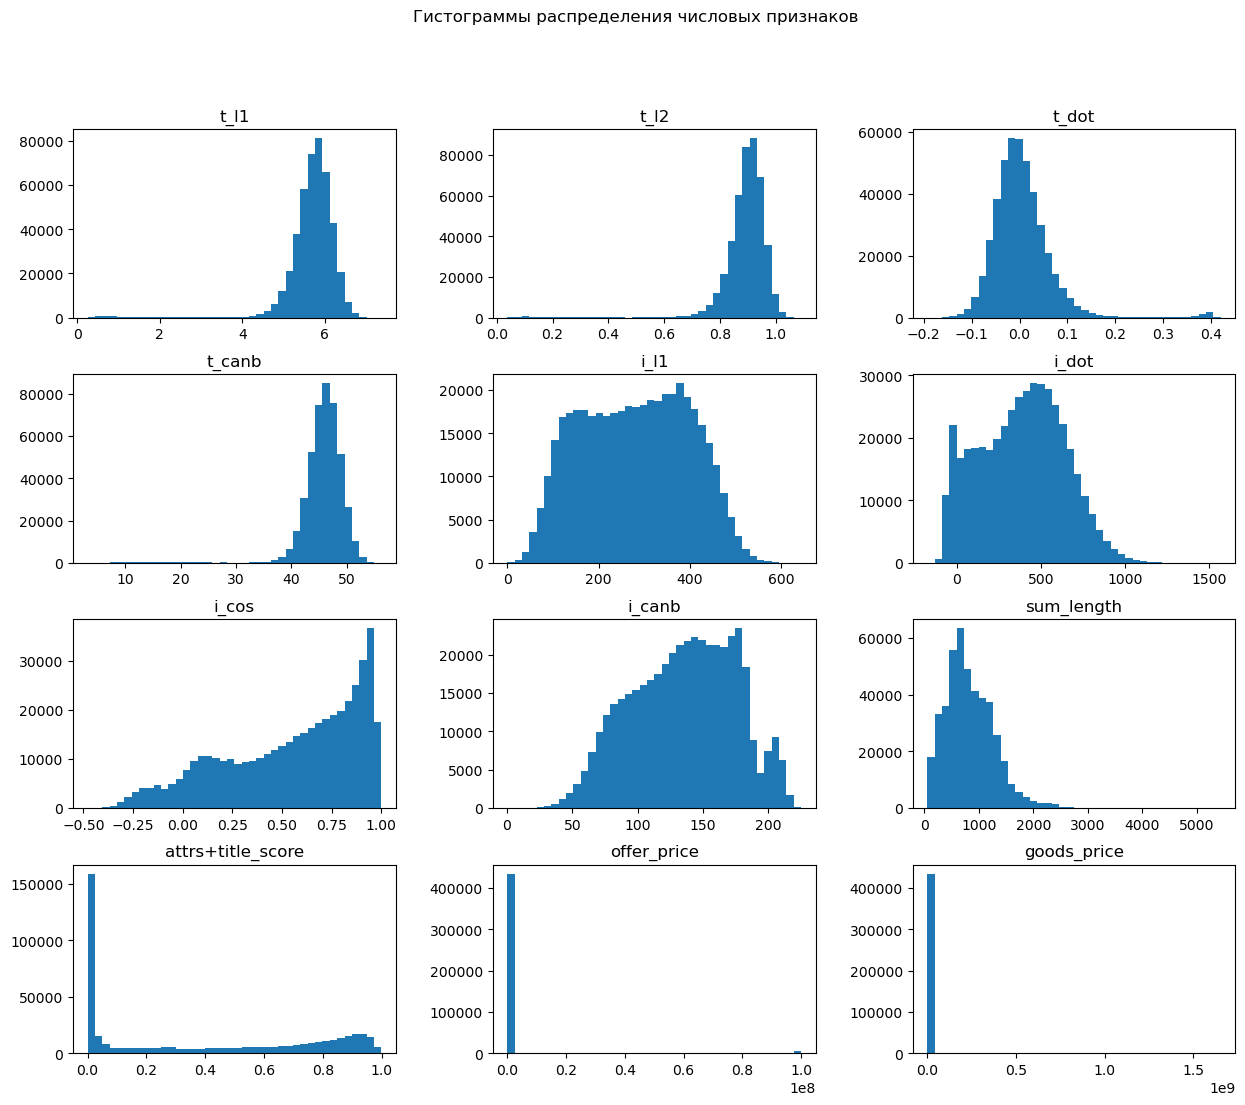

In [100]:
train_df[train_df['i_l1'] != -999][num_cols].hist(bins=40, figsize=(15, 12), grid=False);
plt.suptitle('Гистограммы распределения числовых признаков');

Диаграммы размаха:

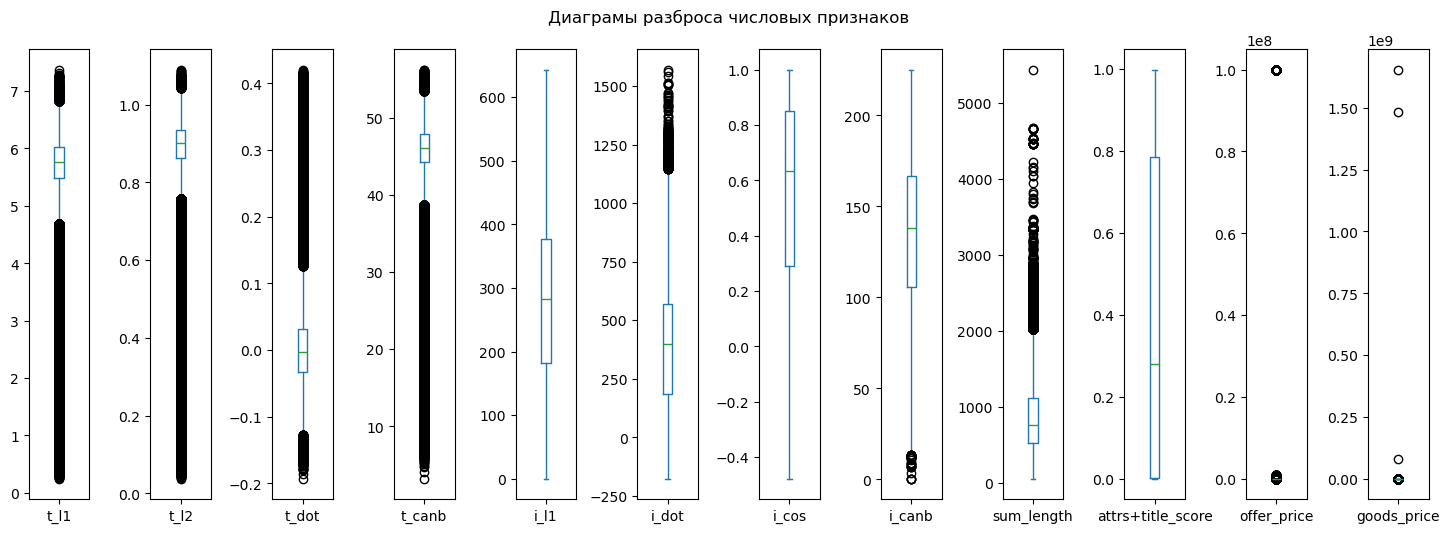

In [94]:
train_df[train_df['i_l1'] != -999][num_cols].plot.box(subplots=True, figsize=(14, 5), title='Диаграмма размаха числовых признаков');
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=1, hspace=0.1);

Заметные неадекватные значения `offer_price` и `goods_price`

Распределение категориальных признаков:

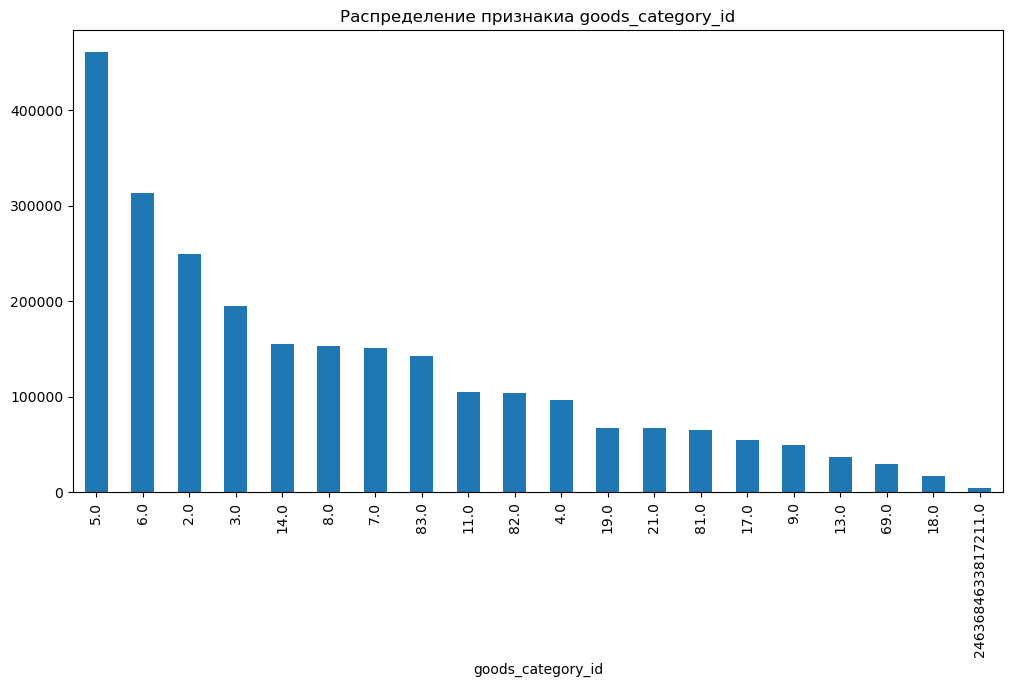

In [37]:
train_df['goods_category_id'].value_counts().plot.bar(figsize=(12, 6),
                                                     title='Распределение признакиа goods_category_id');

Неадекватно высокое значение для категории товаров. В процессе предобработки для экономии занимаемой памяти будет заменено.

Для тестовой выборки:

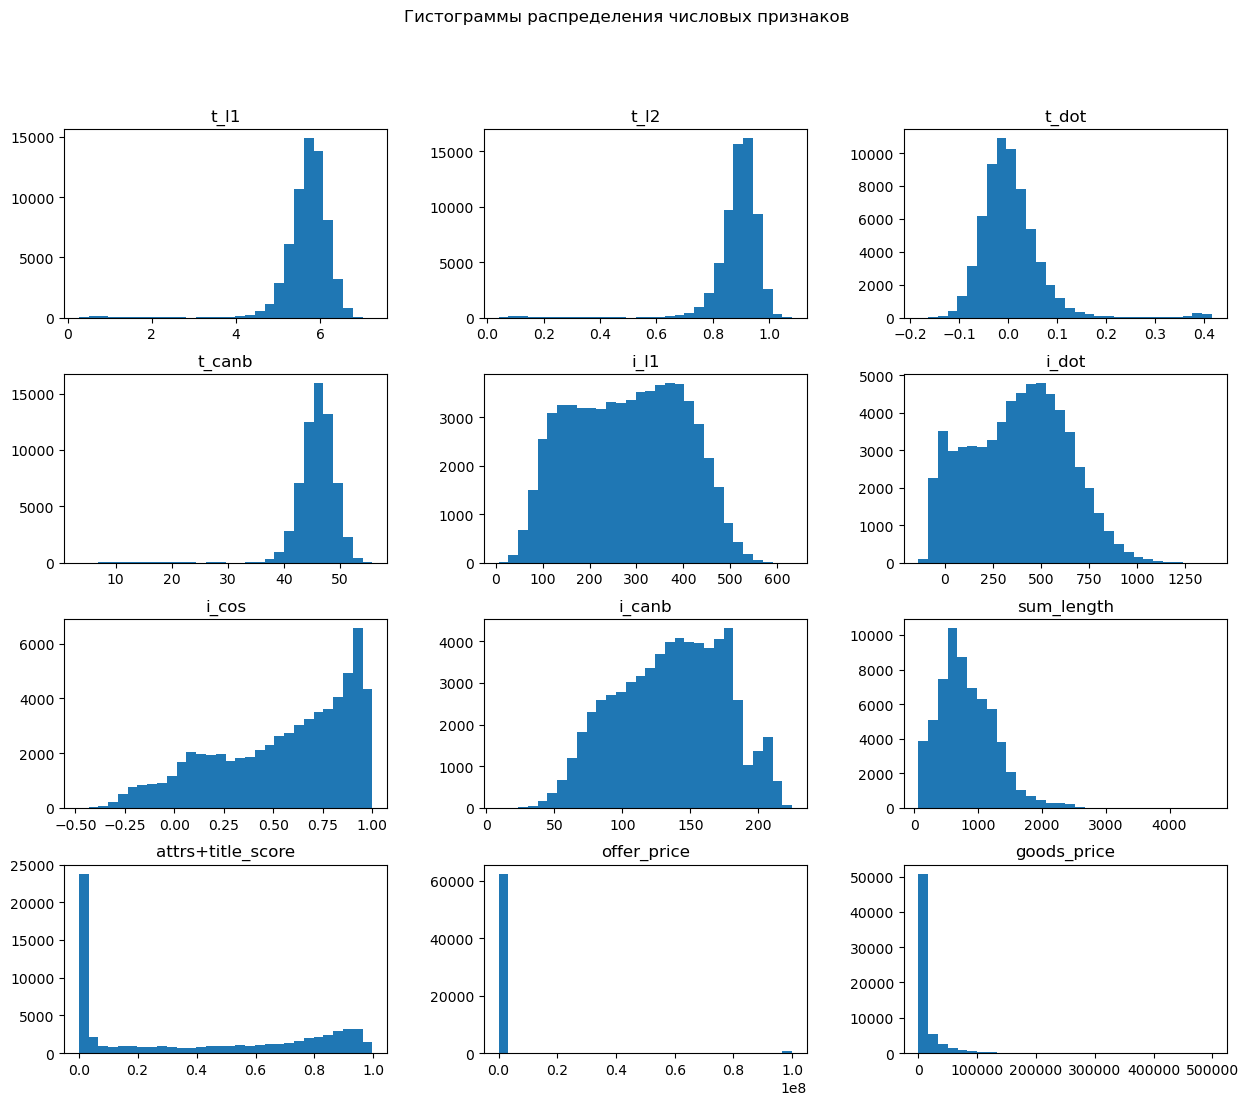

In [99]:
test_df[test_df['i_l1'] != -999][num_cols].hist(bins=30, figsize=(15, 12), grid=False);
plt.suptitle('Гистограммы распределения числовых признаков');

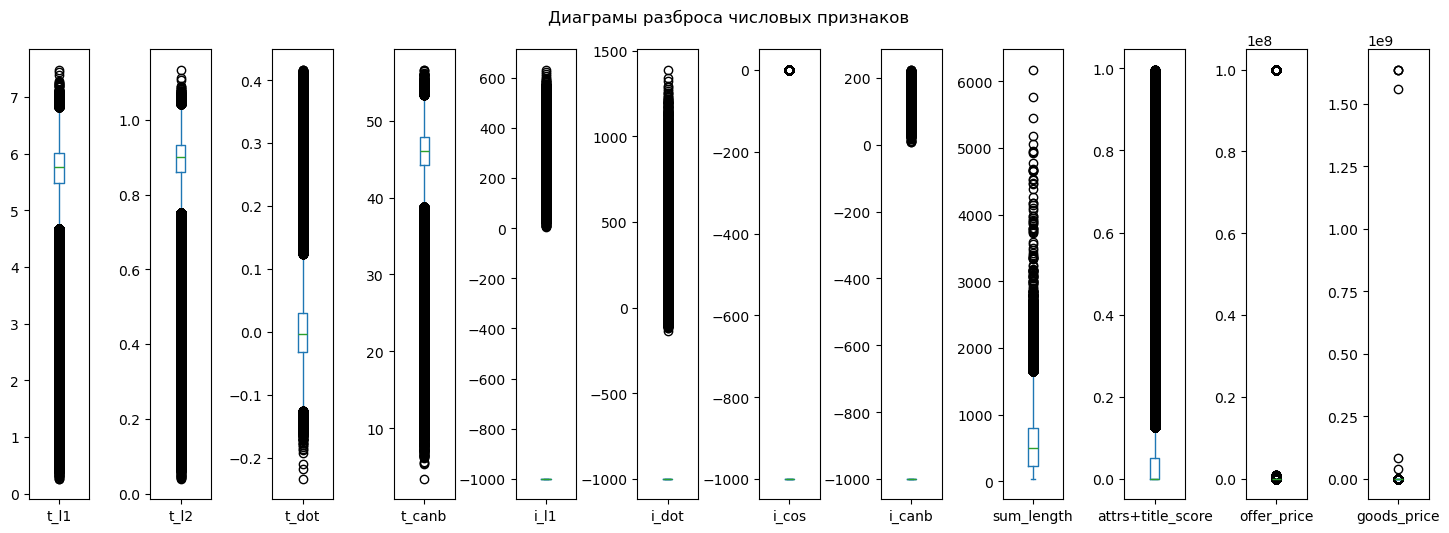

In [93]:
test_df[num_cols].plot.box(subplots=True, figsize=(14, 5), title='Диаграмма размаха числовых признаков');
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=1, hspace=0.1);

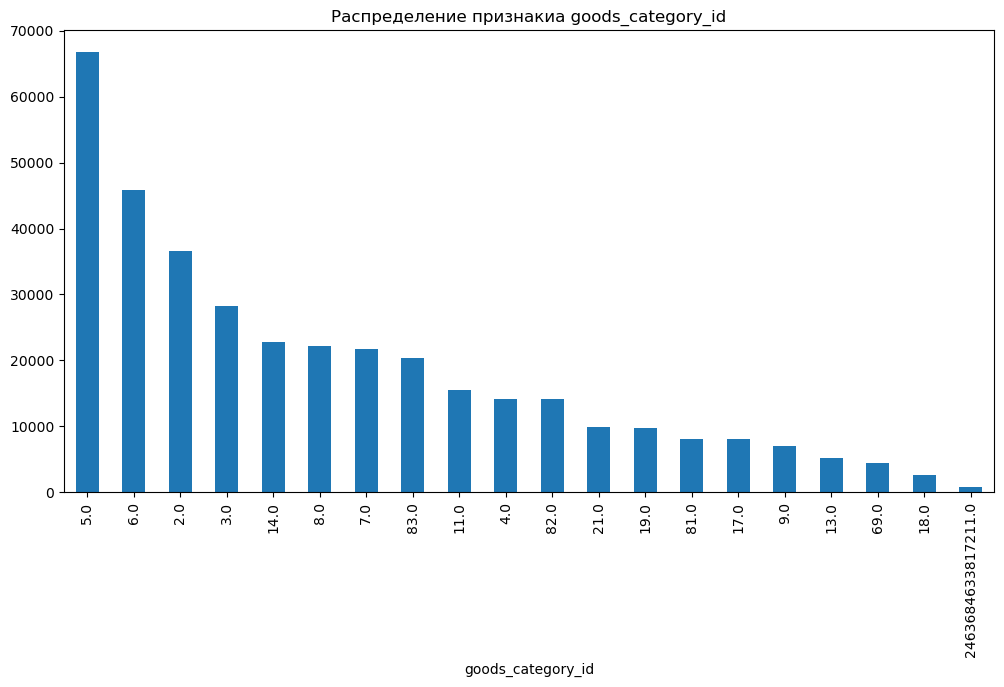

In [40]:
test_df['goods_category_id'].value_counts().plot.bar(figsize=(12, 6),
                                                     title='Распределение признакиа goods_category_id');

Распределение целевой переменной:

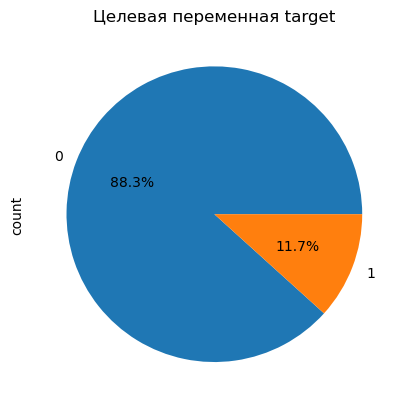

In [41]:
train_df[tar_col].value_counts().plot.pie(autopct='%1.1f%%', title='Целевая переменная target');

Явный дисбаланс классов. Будет уместно использовать методики устранения дисбаланса при обучении моделей.

Проверка скоррелированности числовых признаков:

In [67]:
train_df[train_df['i_l1'] != -999][num_cols+[tar_col]].corr().style.background_gradient(cmap='PiYG', vmin=-1, vmax=1).format('{:,.1%}')

In [68]:
test_df[test_df['i_l1'] != -999][num_cols].corr().style.background_gradient(cmap='PiYG', vmin=-1, vmax=1).format('{:,.1%}')

Признаки `i_l1`, `i_l2` скоррелированы абсолютно, имеет смысл от одного из них избавиться,
Абсолютно скоррелированы `t_cos` и `t_dot`, один из них тоже лишний

Сильна корреляция между признаками векторных расстояний как текстовых эмбеддингов, так и эмбеддингов изображений, в том числе сильная отрицательная корреляция признаков `t_dot` и `t_l1`, `t_dot` и `t_l2`

Целевая переменная показывает некоторый уровень корреляции с признаками векторных расстояний эмбеддингов изображений, а также с признаком рескоринговой модели - `attrs+title_score`

### Выводы: исследовательский анализ данных
- В распределении признаков `goods_category_id`, `offer_price` и `goods_price` обнаружены аномалии в экстремальных значениях
- Признаки `i_l2`, `i_l1` a также `t_cos` и `t_dot` абсолютно скоррелированы, лишние будут удалены
- Обнаружены выбросы в признаках `offer_price` и `goods_price` и пропуски признаках `goods_price` и `goods_category_id`.
- В распределении значений ключевой переменной обнаружен сильный дисбаланс (1 к 8)
- Примерно у 7 из 10 пар товаров нулевая вероятность мэтчинга рескоринговой модели `attrs+title_score`
- Целевая переменная скоррелирована с признаками векторных расстояний эмбеддингов изображений, а также с сильно скоррелирована с признаком вероятности рескоринговой модели - `attrs+title_score`

## Предобработка данных

Удаление лишних признаков:

In [5]:
cols_to_drop.update(['i_l2', 't_cos'])
cols_to_drop

{'i_l2', 't_cos'}

In [6]:
for col in cols_to_drop:
    num_cols.remove(col)
    float_cols.remove(col)


Объявление необходимых в дальнейшем функций:

In [35]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    '''Класс для выбора определенных колонок cols в из датафрейма в пайплайне'''
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X.loc[:, self.cols]

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        pass


class IMG_PCA_wrapper(TransformerMixin, BaseEstimator):
    '''Класс для обработки эмбеддингов изображений в пайплайне методом главных компонент
    Фильтрует пропуски\заглуши и применяет PCA только на эмбеддинги, возвращает датафрейм'''
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components, random_state=random_state)

    def transform(self, X):
        self.nonul_inds = X.iloc[:, 0] != -999
        X = pd.merge(
            pd.DataFrame(self.pca.fit_transform(X.loc[self.nonul_inds]), index=X[self.nonul_inds].index),
            X.iloc[:, -1],
            how='right',
            left_index=True,
            right_index=True
        ).iloc[:, :-1].fillna(-999).astype("float32")
        X.columns = X.columns.astype(str)
        return X

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        pass

# class TITL_PCA_wrapper(TransformerMixin, BaseEstimator):
#     def __init__(self, n_components):
#         self.n_components = n_components
#         self.pca = PCA(n_components=self.n_components, random_state=random_state)

#     def transform(self, X):
#         X = self.pca.fit_transform(X).astype("float32")
#         return X

#     def fit(self, X, y=None):
#         return self

#     def get_feature_names_out(self):
#         pass

class PrepareData():
    '''Класс для постобработки данных'''
    def __init__(self, df_train, df_test):
        self.target = df_train['target']
        self.train = df_train.drop(['target', 'id'], axis=1)
        self.test = df_test.drop('id', axis=1)
        self.dfs = [self.train, self.test]
        
        opts = {
            'model': LGBMRegressor,
            'params': {
                'objective':'regression',
                'learning_rate': 0.05,
                'n_estimators': 340,
                'num_leaves': 250,
                'min_child_samples': 55,
                'force_col_wise': 'true'
            },
            'limit': None,
            'type': 'int32'
        }
        
        self.options = {}
        self.options['goods_price'] = opts | {'limit': .99997}
        self.options['offer_price'] = opts | {'limit': .99}
        self.options['goods_category_id'] = opts | {'model': LGBMClassifier, 'type': 'int8'}
        self.options['goods_category_id']['params'] = opts['params'] | {'objective':'multiclass',
                                                                        'num_class': 20,
                                                                        'metric': 'multi_logloss'} 

    def preprocess(self):
        '''Создание новых признаков abs_price_diff и price_ratio,
        а также замена категории 2463684633817211 на 127 для помещение признакак в int8'''
        for df in self.dfs:
            df['price_ratio'] = df.apply(lambda x: x['offer_price']/x['goods_price'], axis=1).replace({np.inf: 10000}).astype('float32')
            df['abs_price_diff'] = df.apply(lambda x: abs(x['goods_price']-x['offer_price']), axis=1).astype('int32')
            df['goods_category_id'].replace(2463684633817211, 127)
            num_cols.extend(['price_ratio', 'abs_price_diff'])
            float_cols.extend(['price_ratio', 'abs_price_diff'])
        
        
    def correct_outls_boosting(self):
        '''Корректировка пропусков и выбросов с помощью бустинга'''
       
        def split_w_pca(column, limit, pca=True):

            transformer = ColumnTransformer(
            transformers=[
                ('titl_pca', TITL_PCA_wrapper(n_components=5), titl_embs),
                     ],
                remainder='passthrough',
                verbose_feature_names_out=False,
                n_jobs=-1
            ).set_output(transform="pandas")
            
            trains = []
            to_infers = []
            for df in self.dfs:
                if limit != None:
                    df.loc[df[column] >= limit, column] = np.nan
                trains.append(df[~df[column].isna()])
                to_infers.append(df[df[column].isna()])
    
            if pca:
                transformer = transformer.fit(trains[0])
                for df_i in range(2):
                    trains[df_i] = transformer.transform(trains[df_i])
                    to_infers[df_i] = transformer.transform(to_infers[df_i])
                    
            return trains, to_infers
        
        def correct_col_boosting(trains, to_infers, column):
            options = self.options[column]
            lgbm = options['model'](
                random_state=random_state,
                n_jobs=-1,
                **options['params']
            )
            features = trains[0].drop([column]+img_embs, axis=1)
            target = trains[0][column]
            lgbm = lgbm.fit(features, target)
            for df_i in range(2):
                pred = lgbm.predict(to_infers[df_i].drop([column]+img_embs, axis=1))
                self.dfs[df_i].loc[to_infers[df_i].index, column] = pred
                self.dfs[df_i].loc[self.dfs[df_i][column] < 0, column] = 0
                self.dfs[df_i][column] = self.dfs[df_i][column].round().astype(options['type'])
            return self.dfs[0], self.dfs[1]
            
        for column in self.options.keys():
            lim = self.options[column]['limit']
            if lim != None:
                limit = np.quantile(self.dfs[0][column].fillna(self.dfs[0][column].median()), lim)
            else:
                limit = lim
                
            trains, to_infers = split_w_pca(column, limit)
            self.dfs[0], self.dfs[1] = correct_col_boosting(trains, to_infers, column)
        self.dfs[0]['target'] = self.target
        
    def correct_outls_median(self, column):
        '''Корректировка выбросов с помощью медианных значений в группе goods_category_id '''
        for df in self.dfs:
            df[column] = df.groupby('goods_category_id')[column].transform(lambda x: x.fillna(x.median()))
            df.loc[df[column] > self.limit, column] = df.groupby('goods_category_id')[column].transform('median')
            df[column] = df[column].fillna(df[column].median())
            df[column] = df[column].astype('int32')

    def split_train_df(self, test_size=0.1):
        return train_test_split(self.dfs[0].drop('target', axis=1), self.target, random_state=random_state, test_size=test_size)

def load_ppssed_dfs(train=True, test=False, split=False, test_size=.05):
    '''Функция загрузки итоговых датафреймов для train и test
    а также разделение датафрейма train на обучающую и тренировочную выборки'''
    dfs = []
    
    if train:
        df_train = pd.read_parquet(dataset_path+'train_FULL_wonans_outls.lz4')
        if split:
            target = df_train['target']
            features = df_train.drop('target', axis=1)
            features_train, features_val, target_train, target_val = train_test_split(
                features,
                target,
                stratify=target,
                test_size=test_size,
                random_state=random_state
            )
            for i in features_train, features_val, target_train, target_val:
                dfs.append(i)
        else:
            dfs.append(df_train)
            
    if test:
        df_test = pd.read_parquet(dataset_path+'test_FULL_wonans_outls.lz4')
        dfs.append(df_test)
    
    if len(dfs) > 1:
        return dfs
    else:
        return dfs[0]
                
   
    

Разделение датафрейма на тренировочную, валидационную выборки

In [11]:
data = PrepareData(
    pd.read_parquet(dataset_path+'train_FULL_df.lz4'),
    pd.read_parquet(dataset_path+'test_FULL_df.lz4')
)

In [29]:
%env JOBLIB_TEMP_FOLDER=/home/panther/tmp

env: JOBLIB_TEMP_FOLDER=/home/panther/tmp


In [ ]:
data.preprocess()

In [14]:
data.correct_outls_boosting()

[LightGBM] [Info] Total Bins 6397
[LightGBM] [Info] Number of data points in the train set: 2111077, number of used features: 26
[LightGBM] [Info] Start training from score 9279.520282
[LightGBM] [Info] Total Bins 6397
[LightGBM] [Info] Number of data points in the train set: 2493252, number of used features: 26
[LightGBM] [Info] Start training from score 11220.749426
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2517608, number of used features: 26
[LightGBM] [Info] Start training from score -2.313158
[LightGBM] [Info] Start training from score -2.555837
[LightGBM] [Info] Start training from score -3.263461
[LightGBM] [Info] Start training from score -1.698925
[LightGBM] [Info] Start training from score -2.085318
[LightGBM] [Info] Start training from score -2.816026
[LightGBM] [Info] Start training from score -2.796849
[LightGBM] [Info] Start training from score -3.918502
[LightGBM] [Info] Start training from score -3.180739
[LightGBM] [In

In [15]:
data.train.to_parquet(dataset_path+'train_FULL_wonans_outls.lz4', compression="lz4")
data.test.to_parquet(dataset_path+'test_FULL_wonans_outls.lz4', compression="lz4")
# data.target.to_frame('target').to_parquet(dataset_path+'target_FULL.lz4', compression="lz4")

In [9]:
# target = pd.read_parquet(dataset_path+'train_ftrs_dists_df.lz4').iloc[:, -1]
# target.to_frame('target').to_parquet(dataset_path+'target_FULL.lz4', compression="lz4")

In [11]:
# test_df = pd.read_parquet(dataset_path+'test_FULL_wonans_outls.lz4')

In [38]:
# train_df = pd.read_parquet(dataset_path+'train_FULL_wonans_outls.lz4')
# test_df = pd.read_parquet(dataset_path+'test_FULL_wonans_outls.lz4')

train_df.to_parquet(dataset_path+'train_FULL_wonans_outls.lz4', compression="lz4")
test_df.to_parquet(dataset_path+'test_FULL_wonans_outls.lz4', compression="lz4")

In [10]:
train_df.head()

i_0    i_1    i_2    i_3    i_4    i_5    i_6    i_7    i_8    i_9  ...  \
0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   
1 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   
2 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   
3 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   
4 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   

      t_canb    t_city  offer_depersanalised  goods_depersanalised  \
0  45.073051  5.515625                295140               1396793   
1  42.449364  5.578125                 65291               1396586   
2  44.763412  5.765625                 39232               1396244   
3  47.524933  5.796875                 39232               1396513   
4  44.220379  5.132812                 65052               1396237   

   sum_length  attrs+title_score  offer_price  goods_price  goods_category_id  \
0          37           0.027267         1070          393               14.0   
1          38           0.050415          698         3637               14.0   
2          38           0.087280          837            0               14.0   
3          38           0.087280          837         1583               14.0   
4          38           0.079773         1085          358               14.0   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 660 columns]

### Выводы: предобработка данных

- После присоединения к датасету эмбеддингов изображения и текста на основе приведения этих векторов к меньшей размерности и применения LightGBM моделей машинного обучения была произведена постобработка данных, включающая в себя заполнение пробелов признаков, коррекцию выбросов, приведение типов колонок к корректным и оптимальным по использованию памяти

- Были рассчитаны относительные и абсолютная разницы цен `price_ratio` и `abs_price_diff`
- Итоговый датафрейм сохранен на диск, чтобы не занимал память

## Обучение и выбор моделей на усеченной выборке

In [8]:
features_train, features_val, target_train, target_val = load_ppssed_dfs(split=True, test_size=0.95)

In [9]:

def parameter_search(model_name, parameters, features, target, verbose=3, jobs=-1, splits=5, iters=100, grid_s=True, factor=3, **kwargs):
    '''Фукнция подбора гиперпараметров
    На вход принимает класс модели, решетку гиперпараметров для поиска, признаки и целевой признак
    Возвращает лучшую из обученных моделей, её гиперпараметры и её луший результат по метрике MAE
    '''
    if grid_s:
        cv = HalvingGridSearchCV(model_name(**kwargs),
                                 param_grid=parameters,
                                 scoring='f1',
                                 cv=StratifiedKFold(n_splits=splits),
                                 verbose=verbose,
                                 n_jobs=jobs,
                                 factor=factor,
                                 aggressive_elimination=True,
                                 min_resources=1000
                                )
    else:
        cv = BayesSearchCV(model_name(**kwargs),
                           search_spaces=parameters,
                           scoring='f1',
                           cv=StratifiedKFold(n_splits=splits),
                           verbose=verbose,
                           n_jobs=jobs,
                           n_iter=iters)
        
    cv.fit(features, target)  
    
    return cv.best_estimator_, cv.best_params_, cv.best_score_

def print_cv_results(params, metric):
    '''Выводит результаты кросс-валидации на экран'''
    print()
    print(f'Лучшие параметры модели: {params}')
    print(f'(train, CV) лучшее F1: {metric:.4f}')
    print()

### Базовая baseline модель для сравнения

In [15]:
base_model = LogisticRegression(random_state=random_state)
base_model.fit(features_train, target_train)
base_pred_val = base_model.predict(features_val)
base_f1_val = f1_score(target_val, base_pred_val)

print(f'(val) f1-score: {base_f1_val}') 

/home/panther/anaconda3/envs/forge/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(val) f1-score: 0.6433442104007893


### Логистическая регрессия

In [19]:
%%time

import warnings
warnings.filterwarnings('ignore', category=UserWarning) 

transformer = ColumnTransformer(
    transformers=[
        ('selec_vec_ftrs', ColumnExtractor(cols=num_cols), features_train.columns),
        ('img_pca', IMG_PCA_wrapper(n_components=10), img_embs),
        ('titl_pca', PCA(n_components=10), titl_embs),
                 ],
    remainder='drop',
    n_jobs=-1
).set_output(transform="pandas")

pipe = Pipeline([
    ('prep', transformer),
    ('scale', StandardScaler()),
    ('spline', SplineTransformer(n_knots=7)),
    ('lr', LogisticRegression())])

lr_param_grid = {
    'lr__C' : np.linspace(1, 17, 5),
    'lr__penalty': ['l2'],
    'lr__solver': ['newton-cg', 'lbfgs'],
    'lr__max_iter': [1000]
}


cv = HalvingGridSearchCV(pipe,
                         param_grid=lr_param_grid,
                         scoring='f1',
                         cv=StratifiedKFold(n_splits=5),
                         verbose=1,
                         n_jobs=-1,
                         factor=3,
                         aggressive_elimination=True,
                         min_resources=1000
)
cv.fit(features_train, target_train) 
lr_cv_model, lr_cv_params, lr_cv_score = cv.best_estimator_, cv.best_params_, cv.best_score_
# lr_cv_model, lr_cv_params, lr_cv_score = grid_search(pipe,
#                                                      lr_param_grid,
#                                                      features_train[num_cols],
#                                                      target_train,
#                                                      random_state=random_state,
#                                                      splits=5,
#                                                      iters=300
#                                                     )
print_cv_results(lr_cv_params, lr_cv_score)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 5
min_resources_: 1000
max_resources_: 125922
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 9000
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 27000
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 81000
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Лучшие параметры модели: {'lr__C': 5.0, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
(train, CV) лучшее F1: 0.8265

CPU times: user 16.5 s, sys: 1.59 s, total: 18.1 s
Wall time: 1min 16s


### Случайный лес

In [24]:
%%time

params = {
    'n_estimators' : [100, 216],
    'criterion': ['entropy'],
    'max_features': ['sqrt', 'log2', None],
    # 'max_features': [None],
    # 'min_weight_fraction_leaf': [0.0, 0.0001, 0.01, 0.1, 0.2, 0.4],
    'min_impurity_decrease': [.00000065, .00000094, 1.6029131115624923e-11],
}

space = {
    'n_estimators': Integer(10, 500, prior='log-uniform', base=10),
    'min_impurity_decrease': Real(1e-12, 1e-4, prior='log-uniform', base=10),
    'criterion': Categorical(['gini', 'entropy']),
    'max_features': Categorical(['sqrt', 'log2', None]),
}
    

rf_cv_model, rf_cv_params, rf_cv_score = parameter_search(RandomForestClassifier, params,
                                                     features_train[:25000],
                                                     target_train[:25000],
                                                     random_state=random_state,
                                                     splits=3,
                                                     class_weight='balanced',
                                                    )

print_cv_results(rf_cv_params, rf_cv_score)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1000
max_resources_: 25000
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 1000
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 6
n_resources: 3000
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 2
n_resources: 9000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 2/3] END criterion=entropy, max_features=sqrt, min_impurity_decrease=6.5e-07, n_estimators=100;, score=(train=1.000, test=0.800) total time=   0.6s
[CV 1/3] END criterion=entropy, max_features=sqrt, min_impurity_decrease=9.4e-07, n_estimators=100;, score=(train=1.000, test=0.676) total time=   0.6s
[CV 3/3] END criterion=entropy, max_features=sqrt, min_impurity_decrease=9.4e-07, n_estimators=100;, score=(train=1.000, test=0.763) total time=   0.6s
[CV 3/3] END criterion=entropy, max_features=sqrt, min_i

### Градиентный бустинг

In [27]:
%%time

pos_uweight_fctr = target_train.value_counts()[0]/target_train.value_counts()[1]

transformer = ColumnTransformer(
    transformers=[
        ('selec_vec_ftrs', ColumnExtractor(cols=num_cols+cat_cols), features_train.columns),
        ('img_pca', IMG_PCA_wrapper(n_components=5), img_embs),
        ('titl_pca', PCA(n_components=5), titl_embs),
                 ],
    remainder='drop',
    verbose_feature_names_out=False,
    n_jobs=-1
).set_output(transform="pandas")

pipe = Pipeline([
    ('prep', transformer),
    ('lgbm', LGBMClassifier())])

lgbm_param_grid = {
    # 'lgbm__learning_rate': [.097],
    'lgbm__n_estimators' : [10, 2000],
    # 'lgbm__n_estimators' : [100],
    'lgbm__learning_rate': [0.021100858709621813, 0.08],
    # 'lgbm__learning_rate': [0.021100858709621813],
    # 'lgbm__num_leaves': [100],
    'lgbm__num_leaves': [1500, 100],
    'lgbm__min_child_samples': [15, 30],
    # 'lgbm__force_col_wise': ['true', 'false'],
    # 'lgbm__reg_alpha': [.05416768808943605],
    # 'lgbm__reg_lambda': [0.013055638045890137],
    'lgbm__verbose': [-1],
    # 'lgbm__reg_alpha': [.05416768808943605, 2.615489928169622e-05],
    'lgbm__reg_lambda': [.366720294812776, 0.013055638045890137],
    # 'reg_alpha': [2.615489928169622e-05],
    # 'reg_lambda': [0.013055638045890137]
}


space = {
    'lgbm__n_estimators': Integer(50, 3000, prior='log-uniform', base=10),
    'lgbm__max_depth': Integer(2, 50, prior='uniform'),
    'lgbm__num_leaves': Integer(10, 17000, prior='log-uniform', base=10),
    'lgbm__min_child_samples': Integer(13, 100, prior='log-uniform', base=10),
    'lgbm__learning_rate': Real(1e-2, 0.2, prior='log-uniform', base=10),
    'lgbm__reg_alpha': Real(1e-5, 1, prior='log-uniform', base=10),
    'lgbm__reg_lambda': Real(1e-5, 1, prior='log-uniform', base=10)
}



# cv = BayesSearchCV(
#         pipe,
#         search_spaces=space,
#         scoring='f1',
#         cv=StratifiedKFold(n_splits=3),
#         verbose=1,
#         n_jobs=-1,
#         n_iter=50
# )
# cv.fit(features_train, target_train) 


cv = HalvingGridSearchCV(pipe,
                         param_grid=lgbm_param_grid,
                         scoring='f1',
                         cv=StratifiedKFold(n_splits=5),
                         verbose=1,
                         n_jobs=-1,
                         factor=3,
                         aggressive_elimination=True,
                         min_resources=1000
)
cv.fit(features_train[:25000], target_train[:25000]) 
lgbm_cv_model,  lgbm_cv_params,  lgbm_cv_score = cv.best_estimator_, cv.best_params_, cv.best_score_

print_cv_results(lgbm_cv_params, lgbm_cv_score)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 1000
max_resources_: 25000
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 1000
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 1
n_candidates: 11
n_resources: 1000
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 2
n_candidates: 4
n_resources: 3000
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 9000
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Лучшие параметры модели: {'lgbm__learning_rate': 0.08, 'lgbm__min_child_samples': 15, 'lgbm__n_estimators': 2000, 'lgbm__num_leaves': 100, 'lgbm__reg_lambda': 0.366720294812776, 'lgbm__verbose': -1}
(train, CV) лучшее F1: 0.8345

CPU times: user 19.5 s, sys: 1.3 s, total: 20.8 s
Wall time: 5min 23s


### Ансамблирование

In [31]:
%%time

pos_uweight_fctr = target_train.value_counts()[0]/target_train.value_counts()[1]

lr_params = {
    'C': 1,
    'max_iter': 1000,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'n_jobs': -1
}

lgbm_params = {
    'learning_rate': 0.08,
    'n_estimators': 2000,
    'num_leaves': 1500,
    # 'reg_alpha': 0.05416768808943605,
    'reg_lambda': 0.366720294812776,
    'min_child_samples': 15,
    'scale_pos_weight': pos_uweight_fctr,
    'n_jobs': -1,
    'force_col_wise': 'true'
}

rf_params = {
    'criterion':'entropy',
    'max_features': 'sqrt',
    'min_impurity_decrease': 1.6029131115624923e-11,
    'n_estimators': 216,
    'class_weight':'balanced',
    'n_jobs': -1
}


num_trans = Pipeline(
    steps=[
        ('scale', StandardScaler()),
        ('spline', SplineTransformer(n_knots=7))]
)

cat_trans = Pipeline(
    steps=[
        ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ]
)

pca_prep = ColumnTransformer(
    transformers=[
        ('selec_vec_ftrs', ColumnExtractor(cols=num_cols+cat_cols), features_train.columns),
        ('img_pca', IMG_PCA_wrapper(n_components=10), img_embs),
        ('titl_pca', PCA(n_components=8), titl_embs),
                 ],
    remainder='drop',
    verbose_feature_names_out=False,
    n_jobs=-1
).set_output(transform="pandas")

features_prep = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_cols),
        ('cat', cat_trans, cat_cols)
                 ],
    remainder='passthrough',
    n_jobs=-1
)

pipe1 = Pipeline([
    ('pca_prep', pca_prep),
    ('feat_prep', features_prep),
    ('lr', LogisticRegression(random_state=random_state, **lr_params))
])

pipe2 = Pipeline([
    ('pca_prep', pca_prep),
    # ('col_extract', ColumnExtractor(cols=selected_features[2])),
    ('rf', RandomForestClassifier(random_state=random_state, **rf_params))
    ])

pipe3 = Pipeline([
    ('pca_prep', pca_prep),
    # ('col_extract', ColumnExtractor(cols=pd.DataFrame(selected_features).any().values) ), 
    ('lgbm', LGBMClassifier(random_state=random_state, **lgbm_params))
    ])

sens_vm = VotingClassifier(estimators=[('clf1', pipe1),
                                       ('clf2', pipe2),
                                       ('clf3', pipe3)],
                           voting='soft',
                           weights= [0.3, 0.4, 0.7]
                          )


sens_vm.fit(features_train, target_train)
sens_vm_pred_val = sens_vm.predict(features_val)
sens_vm_f1_val = f1_score(target_val, sens_vm_pred_val)
print(f'(val) f1-score: {sens_vm_f1_val}')

/home/panther/anaconda3/envs/forge/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 14732, number of negative: 111190
[LightGBM] [Info] Total Bins 8181
[LightGBM] [Info] Number of data points in the train set: 125922, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116993 -> initscore=-2.021218
[LightGBM] [Info] Start training from score -2.021218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

### Выводы: подбор и обучение моделей 

Модели показали следующие результаты на валидационной выборке: 

In [33]:

pd.DataFrame({'Модель':['baseline LR',
                        'Логистическая регрессия (cv)',
                        'Случайный лес (cv)',
                        'Градиентный бустинг (cv)',
                        'Ансамблирование'
                       ],
             'f1':[round(i, 3) for i in [base_f1_val,
                                         lr_cv_score,
                                         rf_cv_score,
                                         lgbm_cv_score,
                                         sens_vm_f1_val]
                  ]
             },
            ).set_index('Модель').T

Модель  baseline LR  Логистическая регрессия (cv)  Случайный лес (cv)  \
f1            0.643                         0.827                0.82   

Модель  Градиентный бустинг (cv)  Ансамблирование  
f1                         0.835            0.872

Очевидным выбором является использование модели на основе ансамбля других моделей, точнее - VotingClassifier на основе линейной регрессии, случайного леса и градиентного бустинга.

## Предсказание на тестовой выборке и результат

In [36]:
test_df = load_ppssed_dfs(train=False, test=True)

In [34]:
# import pickle

# save
# with open(dataset_path + 'lgbm_tv.pkl','wb') as f:
#     pickle.dump(lgbm, f)

# with open(dataset_path + 'ens_vm_model.pkl','rb') as f:
#     ens_vm_model= pickle.load(f)
# ens_vm_model.predict(features_val)

Итоговая таблица с результатами:

In [ ]:
pred_test = sens_vm.predict(test_df)

In [40]:
results = pd.Series(pred_test, name='target')
results

0         0
1         0
2         0
3         0
4         0
         ..
363830    0
363831    0
363832    0
363833    0
363834    0
Name: target, Length: 363835, dtype: int8

## Общий вывод

В ходе данного исследования для решения задачи бинарной классификации (матчинга между товарами) были обучены и проверены 4 моделей машинного обучения:

- Логистическая регрессия
- Случайный лес
- LightGBM реализация градиентного бустинга
- Ансамблевая модель voting classifier на основе тех моделей выше

В ходе исследования было обнаружено, что лучше всего с задачей справляется комплексная ансамблевая модель на усеченном признаковом пространстве, где признаки изображений и текста, закодированные в эмбеддинги, подвергнуты дальнейшему изменению размерности методом основных компонент.

- В результате исследования для предстказания матча выбрана и обучена модель на базе ансамбля моделей линейной регрессии, случайного леса и градиентного бустинга. Получено значение по метрике качества f-1 ~0.9 



___